# **Predicting Calamity: Finding Keyword Trends in Corporate Email Traffic**
# DATA 604 Project 

#### By: 
#### Tyler Snow
#### Gopinath Mohanasundaram
#### Sai Rakshit Goud Pudari

#### **Purpose**: 
> Could an independent entity, searching for trending words in email traffic, have predicted that a significant event was about to occur?

#### **Objectives**: 
> Use big data tools, including simulated streaming, to find “real-time,” accelerating keyword trends in email traffic.
> Answer the following questions:
> - Which keyword trends appeared before, during, and after the collapse of Enron?
> - Were the differences in trends significant between the three phases?
> - Could HR have predicted the calamity based on accelerating trend keywords in email traffic?

> Track and identify sources of suspicious trends and identify their social networks.  
 

##### Enron Dataset can be downloaded from: https://www.kaggle.com/datasets/wcukierski/enron-email-dataset?select=emails.csv

#### Installs

In [4]:
#pip install graphframes-py==0.10.0
#pip install graphframes

#### Imports

In [6]:
import os
import re
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import glob
import time

# src
from src import utils, data_cleaning, data_extraction, kwfa, sentiment_analysis, data_viz

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, FloatType, DateType
import pyspark.pandas as ps
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, RegexTokenizer
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract, to_timestamp, regexp_replace, date_format, lower, desc, lag, to_date, explode, count, udf, hour, year

# Natural Language Tool Kit (NLTK)
import nltk
from nltk.corpus import stopwords, names, words
from nltk.sentiment import SentimentIntensityAnalyzer # VADER

/opt/anaconda3/lib/python3.12/site-packages/pyspark/pandas/__init__.py:43: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [7]:
# Start Timer
print('Starting timer...')
start = time.time()

Starting timer...


## Part I: Data Extraction and Cleaning

### Data Extraction & Preprocessing

In [10]:
# Step 1: Create a Spark session
data_ext_session = utils.create_spark_session("CorporateEmailDataCleaning")

# Step 2: Fix Spark 3.x datetime parsing issue
data_ext_session.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Step 3: Load the dataset 
input_path = "Enron_Emails.csv"

# Step 4: Run preprocessing
preproc_df = data_extraction.extract_emails(data_ext_session, input_path)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/19 12:53:46 WARN Utils: Your hostname, Tylers-Mac-mini.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.237 instead (on interface en1)
25/11/19 12:53:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/19 12:53:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Dataset loaded successfully with multiline support.
root
 |-- file: string (nullable = true)
 |-- message: string (nullable = true)

+---------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|file                 |message                                                                                                                                                                                                                                                                                                              

+------------------------+--------------+------------+-------------------+-----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|file                    |sender        |recipient   |date_time          |subject          |body                                                                                                                                                                                             |
+------------------------+--------------+------------+-------------------+-----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|allen-p/_sent_mail/1000.|Allen, Phillip|Gay, Randall|2000-10-23 09:13:00|Mime-Version: 1.0|Randy,\n\n Can you send me a schedule of the sa

+-------+--------------+----------------+--------------------+
|  month|        sender|       recipient|                body|
+-------+--------------+----------------+--------------------+
|2000-10|Allen, Phillip|    Gay, Randall|Randy,\n\n Can yo...|
|2001-05|Allen, Phillip|        rlehmann|Reagan,\n\nJust w...|
|2000-09|Allen, Phillip|     Rangel, Ina|-----------------...|
|2000-09|Allen, Phillip|          cbpres|George,\n\n Here ...|
|2000-09|Allen, Phillip|     Rangel, Ina|-----------------...|
|2000-09|Allen, Phillip|          dexter|-----------------...|
|2000-08|Allen, Phillip|  stagecoachmama|Lucy,\n I got you...|
|2000-08|Allen, Phillip|Hargrove, Mac, D|Mac,\n\n Thanks f...|
|2000-08|Allen, Phillip|        pallen70|-----------------...|
|2000-08|Allen, Phillip|Hargrove, Mac, D|I checked into ex...|
+-------+--------------+----------------+--------------------+
only showing top 10 rows


### Data Cleaning

#### Functions

#### Steps:
> - Remove punctuation
> - Lower case text from body
> - Remove non-keyword text from body, e.g. names, articles, pronouns, etc.

In [14]:
# Step 5: Clean email bodies and write to CSV files
data_cleaning.write_clean_emails(preproc_df)

Years covered in original dataset: [Row(year=1), Row(year=2), Row(year=1979), Row(year=1986), Row(year=1997), Row(year=1998), Row(year=1999), Row(year=2000), Row(year=2001), Row(year=2002), Row(year=2004), Row(year=2005), Row(year=2007), Row(year=2012), Row(year=2020), Row(year=2024), Row(year=2043), Row(year=2044)]


Years covered in filtered dataset: [Row(year=1999), Row(year=2000), Row(year=2001)]


+----------+----+--------------+------------+--------------------+
|      date|year|        sender|   recipient|        cleaned_body|
+----------+----+--------------+------------+--------------------+
|2000-10-23|2000|Allen, Phillip|Gay, Randall|randy send schedu...|
|2001-05-03|2001|Allen, Phillip|    rlehmann|reagan  just want...|
|2000-09-25|2000|Allen, Phillip| Rangel, Ina|forwarded allenho...|
|2000-09-19|2000|Allen, Phillip|      cbpres|george sales numb...|
|2000-09-06|2000|Allen, Phillip| Rangel, Ina|forwarded allenho...|
+----------+----+--------------+------------+--------------------+
only showing top 5 rows


Sample from 1999:



+----------+--------------------+
|      date|        cleaned_body|
+----------+--------------------+
|1999-12-10|naomi  the two an...|
|1999-12-10|naomi  the two an...|
|1999-12-30|and family new ye...|
|1999-12-15|vacation     phil...|
|1999-12-13|send future lists...|
+----------+--------------------+
only showing top 5 rows


Sample from 2000:



+----------+--------------------+
|      date|        cleaned_body|
+----------+--------------------+
|2000-10-23|randy send schedu...|
|2000-09-25|forwarded allenho...|
|2000-09-19|george sales numb...|
|2000-09-06|forwarded allenho...|
|2000-09-05|forwarded allenho...|
+----------+--------------------+
only showing top 5 rows


Sample from 2001:



+----------+--------------------+
|      date|        cleaned_body|
+----------+--------------------+
|2001-05-03|reagan  just want...|
|2001-04-26|ray  is detail ga...|
|2001-04-25|gary  here photog...|
|2001-04-24|griff  it bidweek...|
|2001-05-11|let know get quot...|
+----------+--------------------+
only showing top 5 rows


In [15]:
# Step 6: Stop Spark session
data_ext_session.stop()

### Part II: Keyword Frequency Acceleration
> Before starting:
>  - Restart kernel (new Spark session)

#### Steps

In [18]:
# Step 1: Create Spark session with schema
kfa_session = utils.create_spark_session("KeywordTrendAcceleration")

schema = StructType([
    StructField('date', DateType(), True),
    StructField('cleaned_body', StringType(), True)
])

In [19]:
# Step 2: Run data pipeline
kw_trend_acc_df = kwfa.run_pipeline(kfa_session, schema, "clean_body_emails", "monthly_trends")

In [20]:
# Step 3: Stop Spark session
kfa_session.stop()

##### **Reflections**:
> - Some useful keywords are popping up:
>     - enron (2001-10)
>     - error (2001-04) 
>     - dynegy, houston (2001-11) (Referring to buyout deal shortly before collapse.)

##### **Next Steps**:
> - Find sentences with these keywords.
> - Use sentiment analysis to find sentences and emails.

## Part III: Sentiment Analysis
> Before starting:
>  - Restart kernel (new Spark session)

#### Steps

> From Spark DF, select rows where acceleration is greater than or equal to 10000, and and put that rows token and date in tuple, kw_month, defined as (token, YY-mmm)
> 
> From Spark DF, extract sentences from emails matching keyword and month.
> 
> Calculate the sentiment using all sentences containing keywords from that month.
>  
> Merge results of all keywords into one Pandas df

In [26]:
# Step 1: Setup VADER
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Step 2: Create Spark session with schema
sentiment_session = utils.create_spark_session("SentenceSentimentExtraction")

schema = StructType([
    StructField('month', DateType(), True),
    StructField('sender', StringType(), True),
    StructField('recipient', StringType(), True),
    StructField('body', StringType(), True)
])

# Step 3: Merge results into one Pandas DataFrame
sentiment_analysis.load_and_extract_sentences(sentiment_session, schema, sia, 'month_body_emails', 'monthly_trends')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/snowgtyler/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Opening "monthly_trends/2001" file


Results printed!
Opening "monthly_trends/2000" file
Results printed!
Opening "monthly_trends/1999" file
Results printed!


In [27]:
# Step 4: Stop Spark session
sentiment_session.stop()

In [28]:
# Step 5: Show sentiment report and write CSV file 

# Export Sentiment Report Settings
token_count_floor = 2 # at least x tokens in sentence
sentiment_level_floor = -.7 # x or lower number sentiment
year = 2001 # year to extract data from

# Read CSV file
sentiment_df = pd.read_csv(f"{year}_results.csv")

# Show sample and write CSV file
sentiment_df[(
    sentiment_df['token_count'] >= token_count_floor) & (sentiment_df['sentiment'] <= sentiment_level_floor)].drop_duplicates()\
    .to_csv(f"sentiment_report_({token_count_floor}+{sentiment_level_floor}).csv", index=False)

sentiment_df[(sentiment_df['token_count'] >= token_count_floor) & (sentiment_df['sentiment'] <= sentiment_level_floor)].drop_duplicates().head(5)

,month,tokens,token_count,sentence,sender,recipient,sentiment
3190,2001-10,"('also', 'get')",2,I also think that the difficulty in AZ will be...,"Steffes, D,","Lawner, Leslie",-0.7430
7022,2001-10,"('would', 'know')",2,i guess we know why it tanked now -- i wonder ...,"Kuykendall, Tori",pkuykendall,-0.7743
7465,2001-10,"('market', 'information')",2,"Some comments made implied that ""you can't tel...","Sewell, Doug","Rodriquez, Andy",-0.7192
11871,2001-10,"('image', 'get')",2,[IMAGE] [IMAGE] [IMAGE] Keep current on Amer...,"10, Iexpect",pmims,-0.8687
12555,2001-10,"('new', 'market', 'information')",3,"A new disturbing angle was that apparently, so...","Rodriquez, Andy","Yeung, Charles",-0.8360


In [47]:
# End Timer
print('Ending timer...')
end = time.time()
print(f'main() took {(end-start)/60:.4} minutes to execute.')

Ending timer...
main() took 19.79 minutes to execute.


## Part IV: Data Visualization

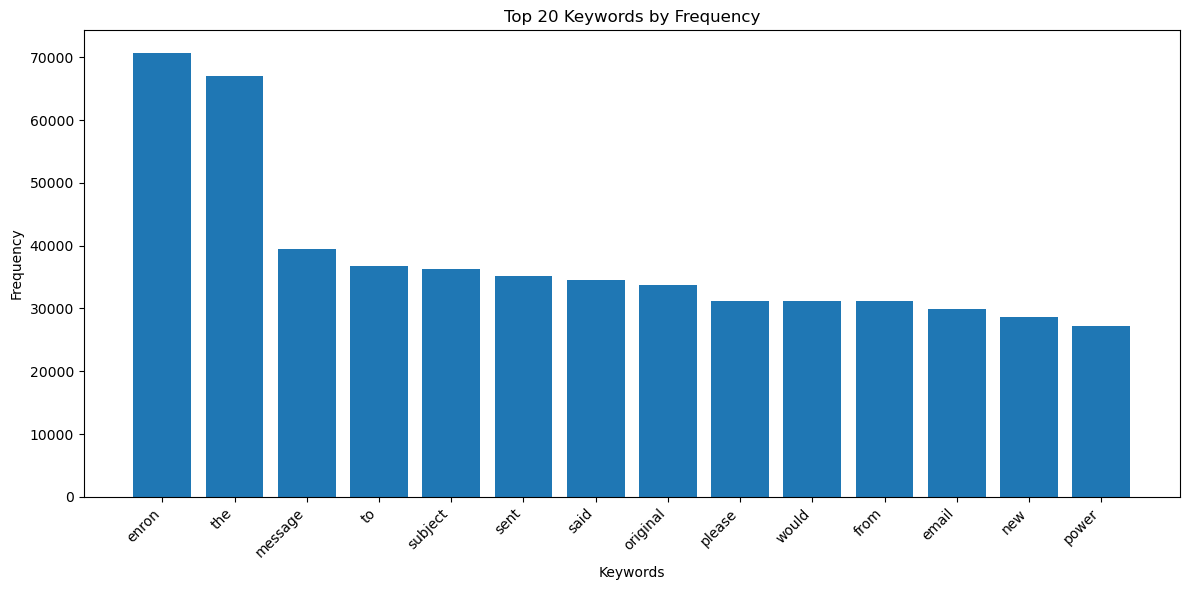

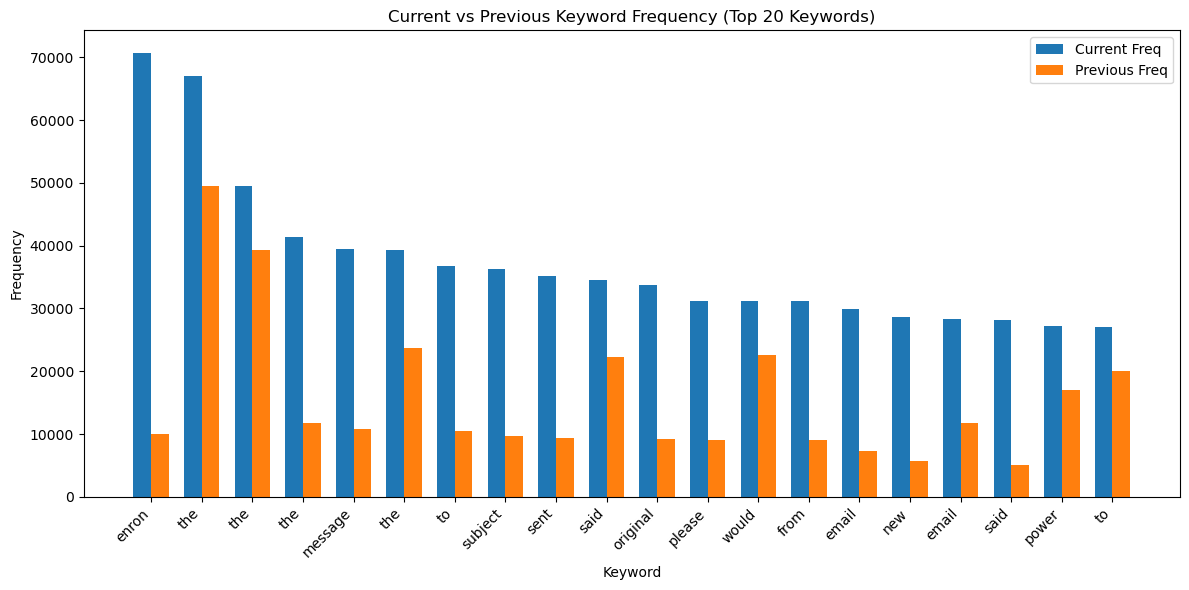

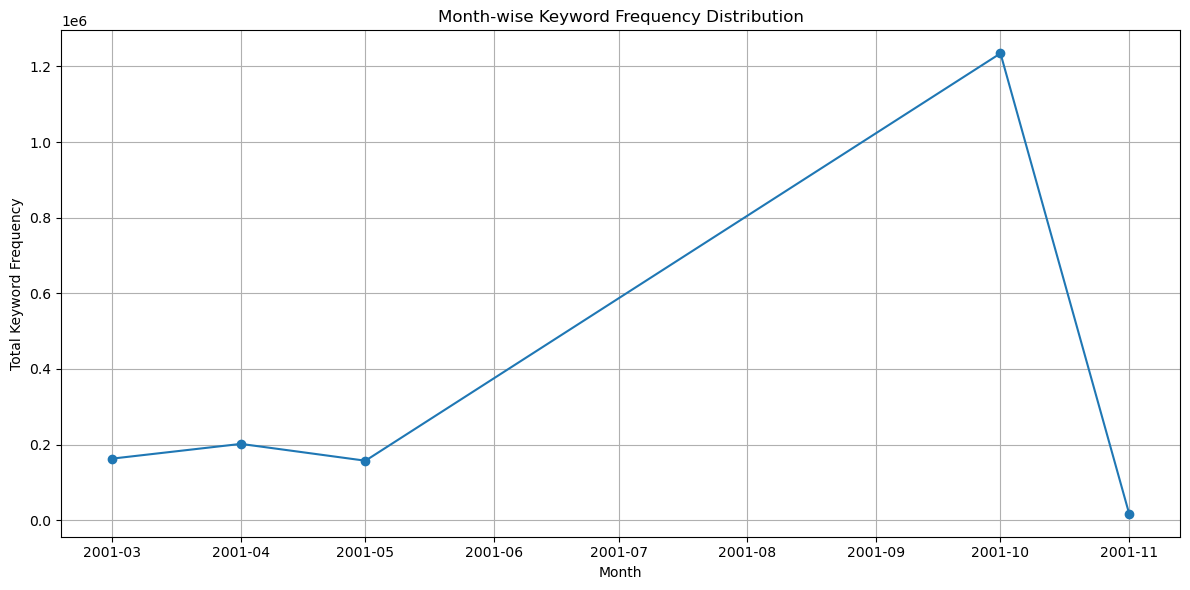

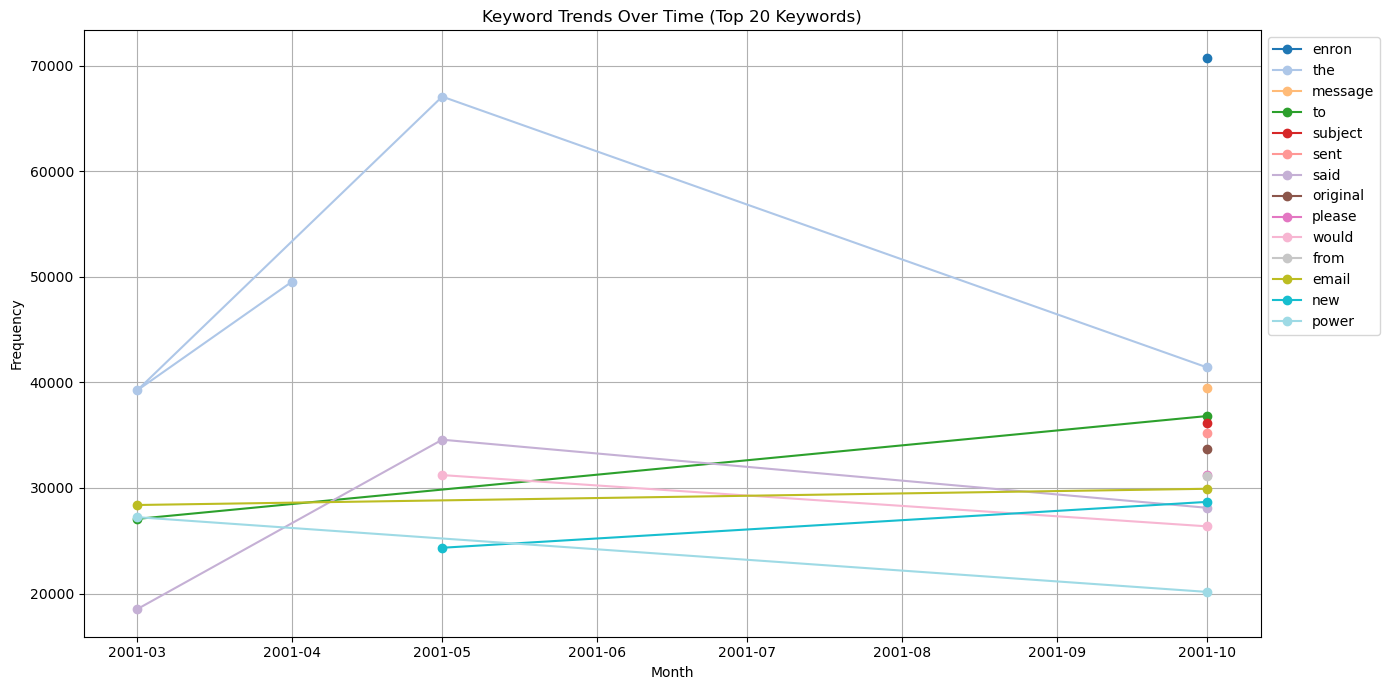

In [31]:
# Data Visualization Settings
year = 2001 # keyword trends from this year

# Plot keyword frequency acceleration statistics
kwfa_file = glob.glob(f"monthly_trends/{year}/part-*.csv")[0]
data_viz.plot_kwfa_stats(kwfa_file)